# Introduction

In this notebook, I examine the neural network approaches. Using the Natural Language Processing in Action book, from Manning Publishing.



In [74]:
import pandas as pd
from nltk import tokenize
%config Completer.use_jedi = False
# this makes autocomplete faster

import matplotlib.pyplot as plt
import seaborn as sns

import adjustText

# only if needed, takes a while
# import spacy
# nlp = spacy.load("en_core_web_lg")

from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import pickle

We need `adjustText` for the labels in charts.GitHub link: https://github.com/Phlya/adjustText

In [2]:
# this is the folder that should be used: 
txt_folder = './data/original/txts_adjusted/'

df = pd.read_csv('./data/original/table_of_contents.csv', header = None, \
                 names = ['original_title', 'page_num','filename','year'])

# skipping first one
filenames =  df['filename'][1:]

# Word Vectors

## Notes

__LSA__: does not capture implied hidden meanings of words. Great for document classification, semantic search, and clustering, but not for semantic reasoning or working with short phrases. In lsa, every word that occurs in same document will have impact on score, now, only the close words will. 

__word vectors__: able to decide things like is this an animal, place, etc, synonyms, word vectors are multidimensional vectors that capture the meaning of a word in different dimensions (e.g. animalness, placeness, etc), and then you can do math on it, e.g. vw(marie curie) - vw(science) + vw(music)

No need to label anything, proximity of words is what matters, so it is unsupervised. In a way, labels are the words near other words in the dataset.

There are two approaches on how to create word vectors: skip-gram approach and continuous bag-of-words (pg 191 in book for details). 

__skip-gram__: divide text into n-grams, with softmax activation, calculate the probability of an output word being found as a surrounding word of an input word. Once training is done, weight matrix will be the embedding. Works well with small corpora and rare terms. 

__continuous b-o-w__: instad of creating input - output tokens, multi-hot vector for all surrounding tokens to the center target token. This approach is more accurate for frequent words, and faster to train. 

Practical concerns: stop words should not be ignored, they might carry meaning, plus word vectors are often used in generative models. So they remain in, and to reduce emphasis, they are sampled in inverse proportion of their frequency. Recommended parameters: small corpus: negative sampling rate of 5-20, large: can reduce to 2 to 5. 

## Pretrained Examples

In [2]:
# this step takes a while
word_vectors = KeyedVectors.load_word2vec_format(\
    './word2vec_pretrained/GoogleNews-vectors-negative300.bin.gz', \
    binary = True, limit = 1000000)

In [15]:
word_vectors.most_similar(positive = ['nice'], topn = 5)

[('good', 0.6836092472076416),
 ('lovely', 0.6676311492919922),
 ('neat', 0.6616737246513367),
 ('fantastic', 0.6569241285324097),
 ('wonderful', 0.6561347246170044)]

In [16]:
word_vectors.most_similar(negative = ['nice'], topn = 5)

[('J.Gordon_###-###', 0.38660115003585815),
 ('M.Kenseth_###-###', 0.35581791400909424),
 ('D.Earnhardt_Jr._###-###', 0.34227001667022705),
 ('G.Biffle_###-###', 0.3420777916908264),
 ('HuMax_TAC_TM', 0.3141660690307617)]

In [8]:
# finding synonyms
word_vectors.most_similar(positive=['france', 'germany'], topn = 10)

[('europe', 0.7222039103507996),
 ('spain', 0.701023519039154),
 ('european', 0.6962700486183167),
 ('german', 0.6810604929924011),
 ('italy', 0.6680153608322144),
 ('england', 0.66745924949646),
 ('usa', 0.6651221513748169),
 ('switzerland', 0.6604776978492737),
 ('sweden', 0.6577832698822021),
 ('india', 0.6428229808807373)]

In [9]:
# finding odd one outs
word_vectors.doesnt_match(['Hitler', 'Churchill', 'Stalin', 'Beethoven'])

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'Beethoven'

In [4]:
# famous math operations
word_vectors.most_similar(positive = ['king', 'woman'], negative = ['man'], topn = 1)

[('queen', 0.7118192911148071)]

In [5]:
word_vectors.most_similar(positive = ['doctor', 'woman'], negative = ['man'], topn = 1)

[('gynecologist', 0.7093892097473145)]

In [6]:
word_vectors.most_similar(positive = ['doctor', 'female'], negative = ['male'], topn = 1)

[('physician', 0.6744842529296875)]

In [12]:
word_vectors.most_similar(positive = ['father', 'woman'], negative = ['man'], topn = 1)

[('mother', 0.8462507128715515)]

In [56]:
word_vectors.most_similar(positive = ['Shakespeare', 'theater'], negative = ['Macbeth'])

[('repertory_theater', 0.5712003707885742),
 ('Theater', 0.5682459473609924),
 ('Theatre', 0.5592392086982727),
 ('performing_arts', 0.5544595718383789),
 ('cinema', 0.5379453897476196),
 ('playhouse', 0.5297478437423706),
 ('musicals', 0.527795672416687),
 ('Playhouse', 0.5240913033485413),
 ('Stagecrafters', 0.5200196504592896),
 ('theatregoing', 0.5177725553512573)]

In [13]:
word_vectors.most_similar(positive = ['music', 'Picasso'], negative = ['Beethoven'], topn = 10)

[('art', 0.5378468036651611),
 ('artists', 0.5258477926254272),
 ('Pablo_Picasso', 0.49319028854370117),
 ('artist', 0.49227362871170044),
 ('artwork', 0.47473448514938354),
 ('painting', 0.46198058128356934),
 ('artist_Robert_Rauschenberg', 0.43100041151046753),
 ('artworks', 0.4306104779243469),
 ('painters', 0.43055960536003113),
 ('photography', 0.42579764127731323)]

In [14]:
word_vectors.most_similar(positive = ['Picasso', 'music'], negative = ['art'], topn = 10)

[('Erroll_Garner', 0.5344928503036499),
 ('songs', 0.5321550965309143),
 ('Beethoven', 0.5134056806564331),
 ('Frampton_Comes_Alive', 0.5108814835548401),
 ("Chico_O'Farrill", 0.5059295892715454),
 ('Jimi_Hendrix', 0.5056772232055664),
 ('Mozart', 0.5042005777359009),
 ('Manu_Dibango', 0.49042925238609314),
 ('Chucho_Valdes', 0.4867725372314453),
 ('Mose_Allison', 0.4866839051246643)]

In [15]:
word_vectors.most_similar(positive = ['China', 'Stalin'], negative = ['Russia'], topn = 10)

[('Mao', 0.7007876634597778),
 ('Chairman_Mao', 0.6467739343643188),
 ('Mao_Zedong', 0.5951652526855469),
 ('Mao_Tse_tung', 0.5835192203521729),
 ('Deng_Xiaoping', 0.5821856260299683),
 ('Chairman_Mao_Zedong', 0.5699514150619507),
 ('Communist', 0.5632455348968506),
 ('Communist_Party_CCP', 0.5581366419792175),
 ('Hu_Yaobang', 0.5552926063537598),
 ('Great_Helmsman', 0.5500338077545166)]

In [16]:
word_vectors.most_similar(positive = ['Germany', 'Stalin'], negative = ['Russia'], topn = 10)

[('Hitler', 0.6709142923355103),
 ('Adolf_Hitler', 0.5992249250411987),
 ('Third_Reich', 0.5972428917884827),
 ('Nazi', 0.5926545858383179),
 ('Nazis', 0.5889713764190674),
 ('Hitler_Third_Reich', 0.5791662931442261),
 ('Hilter', 0.5716949701309204),
 ('Adolph_Hitler', 0.5711631774902344),
 ('Nazi_Germany', 0.5646259784698486),
 ('Fuehrer', 0.5622488856315613)]

In [17]:
word_vectors.most_similar(positive = ['France', 'Stalin'], negative = ['Russia'], topn = 10)

[('Pétain', 0.608258843421936),
 ('Mitterand', 0.5562480688095093),
 ('Maurice_Papon', 0.5539685487747192),
 ('De_Gaulle', 0.5534417033195496),
 ('Petain', 0.5488604307174683),
 ('de_Gaulle', 0.5444628000259399),
 ('François_Mitterrand', 0.5440154075622559),
 ('Vichy', 0.5330964922904968),
 ('Francois_Mitterand', 0.5310631990432739),
 ('Hitler', 0.5308597087860107)]

In [18]:
word_vectors.most_similar(positive = ['Hungary', 'Stalin'], negative = ['Russia'], topn = 10)

[('Ceaucescu', 0.5413000583648682),
 ('Gyula', 0.5344285368919373),
 ('Hitler', 0.5297396183013916),
 ('Imre_Nagy', 0.5281765460968018),
 ('Ferenc', 0.5272859930992126),
 ('Mussolini', 0.5254130959510803),
 ('Miklós', 0.5238747596740723),
 ('László', 0.5185155868530273),
 ('Goebbels', 0.514951229095459),
 ('Sándor', 0.5110854506492615)]

In [17]:
word_vectors.most_similar(positive = ['spain', 'london'], negative = ['england'],  topn = 10)

[('dubai', 0.5724362134933472),
 ('paris', 0.5279353260993958),
 ('orlando', 0.5266646146774292),
 ('los_angeles', 0.5223395228385925),
 ('nyc', 0.5134665966033936),
 ('carlos', 0.5048668384552002),
 ('houston', 0.5046932697296143),
 ('hong_kong', 0.5034560561180115),
 ('las_vegas', 0.5033432841300964),
 ('montreal', 0.49959826469421387)]

Hm. This is quite off. 

## Map

Let's see if we can draw a map of european capitals. 

In [9]:
capitals = [
    'Amsterdam', 'Athens', 'Belgrade', 'Berlin', 'Bern', 
    'Bratislava', 'Brussels', 'Bucharest', 'Budapest', 
    'Chisinau', 'Copenhagen','Dublin', 'Helsinki', 'Kiev',
    'Lisbon', 'Ljubljana', 'London', 'Luxembourg','Madrid',
    'Minsk', 'Monaco', 'Moscow', 'Nicosia', 'Nuuk', 'Oslo', 
    'Paris','Podgorica', 'Prague', 'Reykjavik', 'Riga', 
    'Rome', 'San_Marino', 'Sarajevo','Skopje', 'Sofia', 
    'Stockholm', 'Tallinn', 'Tirana', 'Vaduz', 'Valletta',
    'Vatican', 'Vienna', 'Vilnius', 'Warsaw', 'Zagreb']

# unfortunately, couldn't find this 
nope = ['Andorra_la_Vella']

In [29]:
def plot_2d_representation_of_words(
    word_list, 
    word_vectors, 
    flip_x_axis = False,
    flip_y_axis = False,
    label_x_axis = "x",
    label_y_axis = "y", 
    label_label = "city"):
    """
    does a principal component analysis on word vectors, 
    plots them on a 2d chart
    """
    
    pca = PCA(n_components = 2)
    
    word_plus_coordinates=[]
    
    for word in word_list: 
    
        current_row = []
        current_row.append(word)
        current_row.extend(word_vectors[word])

        word_plus_coordinates.append(current_row)
    
    word_plus_coordinates = pd.DataFrame(word_plus_coordinates)
        
    coordinates_2d = pca.fit_transform(
        word_plus_coordinates.iloc[:,1:300])
    coordinates_2d = pd.DataFrame(
        coordinates_2d, columns=[label_x_axis, label_y_axis])
    coordinates_2d[label_label] = word_plus_coordinates.iloc[:,0]

    if flip_x_axis:
        coordinates_2d[label_x_axis] = \
        coordinates_2d[label_x_axis] * (-1)

    if flip_y_axis:
        coordinates_2d[label_y_axis] = \
        coordinates_2d[label_y_axis] * (-1)
            
    plt.figure(figsize = (12,8))

    p1=sns.scatterplot(
        data=coordinates_2d, x=label_x_axis, y=label_y_axis)
    
    x = coordinates_2d[label_x_axis]
    y = coordinates_2d[label_y_axis]
    label = coordinates_2d[label_label]
    
    texts = [plt.text(x[i], y[i], label[i]) for i in range(len(x))]

    adjustText.adjust_text(texts)
    
    plt.savefig("map.png")


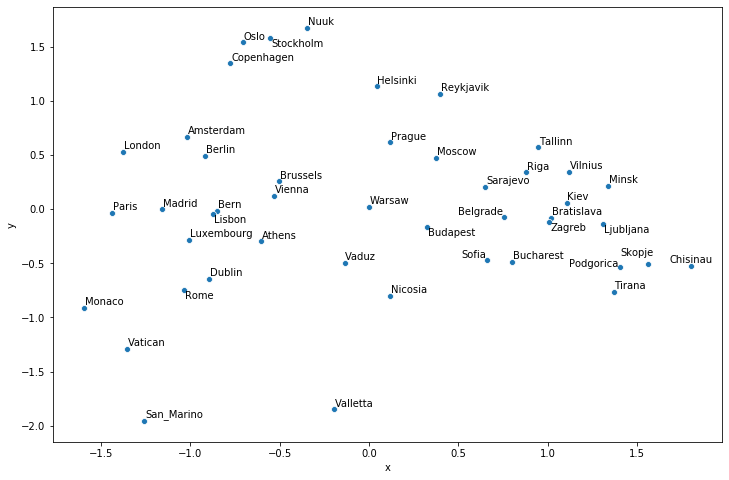

In [30]:
plot_2d_representation_of_words(
    word_list = capitals, 
    word_vectors = word_vectors, 
    flip_y_axis = True)

## Training Own - word2vec

Training on Lovecraft text, trying with the original algorithm first. 

As a first step, we need text split into sentences. 

In [23]:
# trying with one story

my_file = open(txt_folder + 'the_dunwich_horror.txt')
raw_text = my_file.read()
my_file.close()

# create tokenized in the required format, 
# list of sentences, each sentence is a list of tokens

sentences = tokenize.sent_tokenize(raw_text)
sentences_tokenized = []

for sentence in sentences:
    sentence_tokenized = nlp(sentence)
    sentences_tokenized_list = []
    for token in sentence_tokenized:
        sentences_tokenized_list.append(token.lemma_)
    sentences_tokenized.append(sentences_tokenized_list)

In [103]:
model = Word2Vec(
    sentences_tokenized, 
    workers = -1, 
    size = 100, 
    min_count = 3, 
    window = 10, 
    sample = 5)

# increasing sample means that we won't get boring stopwords in the results
# min count = 3, otherwise for example daughter are excluded

model.init_sims(replace = True) 
# to get rid of unnecessary stuff in memory

In [104]:
model.wv.most_similar(positive = ['horror'])

[('watch', 0.2908990979194641),
 ('rite', 0.28141331672668457),
 ('abandon', 0.2760845720767975),
 ('rush', 0.27406400442123413),
 ('complete', 0.26243871450424194),
 ('ready', 0.2602434754371643),
 ('voice', 0.25994643568992615),
 ('none', 0.2586766481399536),
 ('fail', 0.2547798156738281),
 ('cave', 0.24298059940338135)]

In [105]:
model.wv.most_similar(positive = ['Whateley'], negative = ['horror'])

[('unison', 0.3200337588787079),
 ('everybody', 0.30372485518455505),
 ('community', 0.2893528342247009),
 ('white', 0.281683087348938),
 ('unseen', 0.27846288681030273),
 ('vital', 0.2618259787559509),
 ('Sawyer', 0.24717813730239868),
 ('either', 0.2439933717250824),
 ('tarry', 0.24331888556480408),
 ('month', 0.23465459048748016)]

In [106]:
model.wv.most_similar(positive = ['Rice', 'Professor'], negative = ['Morgan'])

[('sphere', 0.35368138551712036),
 ('quite', 0.29772794246673584),
 ('power', 0.2661077380180359),
 ('even', 0.24735844135284424),
 (';', 0.24534285068511963),
 ('need', 0.24197405576705933),
 ('raound', 0.24109742045402527),
 ('inclined', 0.2403174787759781),
 ('sickly', 0.23939597606658936),
 ('unmistakably', 0.2393909990787506)]

In [111]:
model.wv.doesnt_match(['Armitage', 'Rice', 'Morgan', 'Wilbur', 'Whateley'])

/Users/flatiron/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'Morgan'

Repeating with a different hyperparameter setting. 

In [36]:
model = Word2Vec(
    sentences_tokenized, 
    workers = -1, 
    size = 150, 
    min_count = 5, 
    window = 5, 
    sample = 20)

model.init_sims(replace = True)

In [37]:
model.wv.most_similar(positive = ['horror'])

[('even', 0.2762913405895233),
 ('run', 0.27387917041778564),
 ('Osborn', 0.24285763502120972),
 ('face', 0.22632747888565063),
 ('distance', 0.21938148140907288),
 ('nor', 0.21487723290920258),
 ('something', 0.21195335686206818),
 ('again', 0.19428494572639465),
 ('old', 0.17669382691383362),
 ('half', 0.173443004488945)]

In [38]:
model.wv.most_similar(positive = ['Rice', 'Professor'], negative = ['Morgan'])

[('away', 0.2359006702899933),
 ('frightened', 0.19334784150123596),
 ('some', 0.192066952586174),
 ('cow', 0.18966959416866302),
 ('"', 0.18600395321846008),
 ('month', 0.1852327138185501),
 ('fur', 0.18251380324363708),
 ('if', 0.17968705296516418),
 ('mountain', 0.17530925571918488),
 ('altar', 0.17447912693023682)]

These results seem to be completely random. 

In [40]:
# trying with all the stories

sentences_tokenized = []

for filename in filenames: 
    
    print(filename)

    my_file = open(txt_folder + filename + '.txt')
    raw_text = my_file.read()
    my_file.close()

    # create tokenized in the required format, 
    # list of sentences, each sentence is a list of tokens

    sentences = tokenize.sent_tokenize(raw_text)

    for sentence in sentences:
        sentence_tokenized = nlp(sentence)
        sentence_tokenized_list = []
        for token in sentence_tokenized:
            
            # TODO probably exclude punctuations, do lowercase
            # maybe keep original
            
            sentence_tokenized_list.append(token.lemma_)
        sentences_tokenized.append(sentence_tokenized_list)

the_tomb
dagon
polaris
beyond_the_wall_of_sleep
memory
old_bugs
the_transition_of_juan_romero
the_white_ship
the_doom_that_came_to_sarnath
the_statement_of_randolph_carter
the_terrible_old_man
the_tree
the_cats_of_ulthar
the_temple
facts_concerning_the_late_arthur_jermyn_and_his_family
the_street
celephaïs
from_beyond
nyarlathotep
the_picture_in_the_house
ex_oblivione
the_nameless_city
the_quest_of_iranon
the_moon-bog
the_outsider
the_other_gods
the_music_of_erich_zann
herbert_west_—_reanimator
hypnos
what_the_moon_brings
azathoth
the_hound
the_lurking_fear
the_rats_in_the_walls
the_unnamable
the_festival
the_shunned_house
the_horror_at_red_hook
he
in_the_vault
the_descendant
cool_air
the_call_of_cthulhu
pickman's_model
the_silver_key
the_strange_high_house_in_the_mist
the_dream-quest_of_unknown_kadath
the_case_of_charles_dexter_ward
the_colour_out_of_space
the_very_old_folk
the_thing_in_the_moonlight
the_history_of_the_necronomicon
ibid
the_dunwich_horror
the_whisperer_in_darkness
at_

In [41]:
model = Word2Vec(
    sentences_tokenized, 
    workers = -1, 
    size = 300, 
    min_count = 5, 
    window = 10, 
    sample = 5)

model.init_sims(replace = True)

In [43]:
model.wv.most_similar(positive = ['Cthulhu'])

[('Kalos', 0.20821326971054077),
 ('collect', 0.198687344789505),
 ('straggler', 0.19196133315563202),
 ('backwoods', 0.19010305404663086),
 ('thy', 0.1836623251438141),
 ('shudder', 0.18184515833854675),
 ('lift', 0.18037131428718567),
 ('upon', 0.17957769334316254),
 ("cou'd", 0.178560271859169),
 ('weaken', 0.17794013023376465)]

In [44]:
model.wv.most_similar(positive = ['Nyarlathotep'])

[('beam', 0.2265617996454239),
 ('fix', 0.21004167199134827),
 ('psychologist', 0.20848049223423004),
 ('ancient', 0.20240074396133423),
 ('hallway', 0.1878056824207306),
 ('friend', 0.18628254532814026),
 ('require', 0.18044225871562958),
 ("o'clock", 0.18028804659843445),
 ('steamer', 0.17896586656570435),
 ('small', 0.17890100181102753)]

In [45]:
model.wv.most_similar(positive = ['Armitage'])

[('eighty', 0.21315644681453705),
 ('wrap', 0.20066747069358826),
 ('soon', 0.19899974763393402),
 ('smooth', 0.19140422344207764),
 ('volition', 0.19094344973564148),
 ('agony', 0.1891910284757614),
 ('every', 0.17952460050582886),
 ('together', 0.17825554311275482),
 ('adjust', 0.1757020652294159),
 ('mocking', 0.174333855509758)]

In [51]:
model.wv.most_similar(positive = ['Innsmouth'])

[('abaout', 0.2585300803184509),
 ('scaly', 0.20826557278633118),
 ('understand', 0.20526288449764252),
 ('fine', 0.20021550357341766),
 ('exact', 0.19289813935756683),
 ('ghostly', 0.19059231877326965),
 ('morbidity', 0.1847139596939087),
 ('result', 0.17364315688610077),
 ('detect', 0.17269597947597504),
 ('descendant', 0.1718100607395172)]

Sadly, this is not working. 

In [61]:
model = Word2Vec(
    sentences_tokenized, 
    workers = -1, 
    size = 100, 
    min_count = 10, 
    window = 10, 
    sample = 3)

model.init_sims(replace = True)

In [62]:
model.wv.most_similar(positive = ['Innsmouth'])

[('vacant', 0.3152494728565216),
 ('text', 0.3148627281188965),
 ('vault', 0.30906447768211365),
 ('tent', 0.2965916097164154),
 ('lately', 0.2887550890445709),
 ('immediate', 0.2857893109321594),
 ('detect', 0.28246021270751953),
 ('fine', 0.2754843235015869),
 ('wheel', 0.27450698614120483),
 ('approach', 0.27080610394477844)]

In [63]:
model.wv.most_similar(positive = ['Rice', 'Professor'], negative = ['Morgan'])

[('suppress', 0.3270130157470703),
 ('Square', 0.304298996925354),
 ('horse', 0.29634755849838257),
 ('frightened', 0.2929419279098511),
 ('officer', 0.2921297550201416),
 ('phonograph', 0.28682035207748413),
 ('leg', 0.2858068346977234),
 ('arrest', 0.2834944725036621),
 ('steadily', 0.28207850456237793),
 ('worth', 0.28058332204818726)]

In [64]:
model.wv.most_similar(positive = ['Cthulhu'])

[('finally', 0.3371266722679138),
 ('money', 0.3226736783981323),
 ('thunder', 0.32264983654022217),
 ('fantastic', 0.2971569299697876),
 ('past', 0.2965765595436096),
 ('delight', 0.2945157587528229),
 ('georgian', 0.2927424907684326),
 ('Kalos', 0.28264713287353516),
 ('galley', 0.27633053064346313),
 ('chill', 0.2728365361690521)]

In [66]:
model.wv.most_similar(positive = ['Necronomicon'])

[('opposite', 0.3575073480606079),
 ('compose', 0.3401351869106293),
 ('low', 0.3386682868003845),
 ('island', 0.3158450126647949),
 ('vain', 0.3146776556968689),
 ('unique', 0.2986483573913574),
 ('lattice', 0.29416966438293457),
 ('ter', 0.2831343412399292),
 ('Baharna', 0.27469512820243835),
 ('depend', 0.27294501662254333)]

In [69]:
model.wv.most_similar(positive = ['Dunwich'])

[('insect', 0.3729516267776489),
 ('plaza', 0.35179170966148376),
 ('salt', 0.34895622730255127),
 ('Fenner', 0.33790096640586853),
 ('modern', 0.3140619397163391),
 ('Yuggoth', 0.3105481266975403),
 ('bizarre', 0.3026203215122223),
 ('agree', 0.30226561427116394),
 ('prevent', 0.2990167737007141),
 ('fast', 0.2918969988822937)]

In [72]:
model.wv.most_similar(positive = ['eldritch'])

[('hour', 0.35955265164375305),
 ('rite', 0.3380540907382965),
 ('alive', 0.31731781363487244),
 ('temperature', 0.31301480531692505),
 ('sit', 0.30589741468429565),
 ('poise', 0.3041265904903412),
 ('dull', 0.2940497398376465),
 ('genuine', 0.2865021526813507),
 ('efface', 0.28134462237358093),
 ('western', 0.27990487217903137)]

This is sadly not working, I probably need more data. 

Wanted to try out GloVe, but there is no Python implementation. 

# LSTM

## Small Example

Trying a simpler tutorial first, based on shorter text. 

https://machinelearningmastery.com/develop-character-based-neural-language-model-keras/

In [45]:
filename = "the_music_of_erich_zann"
my_file = open(txt_folder + filename + '.txt')
raw_text = my_file.read()
my_file.close()

# clean file
tokens = raw_text.split()
raw_text = ' '.join(tokens)

In [46]:
# looks OK
# sorted(list(set(raw_text)))
# no ! or ? lol

In [47]:
length = 20
sequences = list()

for i in range(length, len(raw_text)):
    sequence = raw_text[i-length:i+1]
    sequences.append(sequence)

In [48]:
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))

In [49]:
mapping

{' ': 0,
 "'": 1,
 ',': 2,
 '-': 3,
 '.': 4,
 ';': 5,
 'A': 6,
 'B': 7,
 'C': 8,
 'D': 9,
 'E': 10,
 'F': 11,
 'G': 12,
 'H': 13,
 'I': 14,
 'K': 15,
 'L': 16,
 'M': 17,
 'N': 18,
 'O': 19,
 'R': 20,
 'S': 21,
 'T': 22,
 'U': 23,
 'W': 24,
 'Y': 25,
 'Z': 26,
 'a': 27,
 'b': 28,
 'c': 29,
 'd': 30,
 'e': 31,
 'f': 32,
 'g': 33,
 'h': 34,
 'i': 35,
 'j': 36,
 'k': 37,
 'l': 38,
 'm': 39,
 'n': 40,
 'o': 41,
 'p': 42,
 'q': 43,
 'r': 44,
 's': 45,
 't': 46,
 'u': 47,
 'v': 48,
 'w': 49,
 'x': 50,
 'y': 51,
 'z': 52,
 '–': 53}

In [50]:
encoded_sequences = []

for sequence in sequences:
    encoded_seq = [mapping[char] for char in sequence]
    encoded_sequences.append(encoded_seq)

In [55]:
encoded_sequences = np.array(encoded_sequences)
X, y = encoded_sequences[:,:-1], encoded_sequences[:,-1]

In [63]:
vocab_size = len(chars)

In [62]:
# next, one-hot encode
encoded_sequences = [to_categorical(x, num_classes=len(chars)) for x in X]
X = np.array(encoded_sequences)
y = to_categorical(y, num_classes=len(chars))

In [64]:
model = Sequential()
model.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 75)                39000     
_________________________________________________________________
dense_4 (Dense)              (None, 54)                4104      
Total params: 43,104
Trainable params: 43,104
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
 - 8s - loss: 2.9118 - accuracy: 0.1973
Epoch 2/100
 - 8s - loss: 2.4992 - accuracy: 0.3036
Epoch 3/100
 - 8s - loss: 2.3341 - accuracy: 0.3315
Epoch 4/100
 - 8s - loss: 2.2493 - accuracy: 0.3486
Epoch 5/100
 - 8s - loss: 2.1929 - accuracy: 0.3576
Epoch 6/100
 - 8s - loss: 2.1456 - accuracy: 0.3695
Epoch 7/100
 - 9s - loss: 2.1045 - accuracy: 0.3775
Epoch 8/100
 - 9s - loss: 2.0678 - accuracy: 0.3904
Epoch 9/100
 - 8s - loss: 2.0336 - accuracy: 0.4018
Epoch 10/100
 - 9s - loss: 2.0010 - accuracy: 0.4084
Epoch 11/100
 - 8s - loss: 1.9668 - accuracy: 0.4188
Epoch 12/100
 - 8s - loss: 1.9387 - accuracy: 0.4291
Epoch 13/100
 - 8s - loss: 1.9126 - accuracy: 0.4357
Epoch 14/100
 - 8s - loss: 1.8850 - accuracy: 0.4414
Epoch 15/100
 - 9s - loss: 1.8590 - accuracy: 0.4497
Epoch 16/100
 - 9s - loss: 1.8365 - accuracy: 0.4559
Epoch 17/100
 - 9s - loss: 1.8127 - accuracy: 0.4611
Epoch 18/100
 - 8s - loss: 1.7912 - accuracy: 0.4712
Epoch 19/100
 - 8s - loss: 1.7681 - accuracy: 0.4768
Ep

In [69]:
# save the model to file
model.save('model.h5')
# save the mapping
pickle.dump(mapping, open('mapping.pkl', 'wb'))

In [70]:
# can load it in later if we want to

In [72]:
def generate_seq(model, mapping, seq_length, seed_text, n_chars):
    in_text = seed_text
    # generate a fixed number of characters
    for _ in range(n_chars):
        # encode the characters as integers
        encoded = [mapping[char] for char in in_text]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # one hot encode
        encoded = to_categorical(encoded, num_classes=len(mapping))
        # predict character
        yhat = model.predict_classes(encoded, verbose=0)
        # reverse map integer to character
        out_char = ''
        for char, index in mapping.items():
            if index == yhat:
                out_char = char
                break
        # append to input
        in_text += char
    return in_text

In [76]:
print(generate_seq(model, mapping, 20, 'But despite all I have done it remains an humiliating', 100))

But despite all I have done it remains an humiliating and the floor, when I wo kee over the wailly. The plainingl. I have nemer and my manded wither wind


Well, that is not really useful. 

## Full Model

Following chapter 9 in book. Trying to create a character-based text generation. 

In [66]:
# check out this too: https://keras.io/examples/generative/lstm_character_level_text_generation/

In [7]:
# first, we need all the text in one large file
# trying with capital letters as well, plus all weird ones

text = ""

for filename in filenames: 

    my_file = open(txt_folder + filename + '.txt')
    current_text = my_file.read()
    my_file.close()
    text += current_text

In [8]:
len(text)

2631871

In [11]:
# create a dictionary of the characters

chars = sorted(list(set(text)))
char_indices = dict((c,i) for i,c in enumerate(chars))
indices_char = dict((i,c) for i,c in enumerate(chars))

In [12]:
len(chars)

106

In [14]:
# now, we are chopping up the text into sentences

maxlen = 40
step = 3

sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i+maxlen])
    next_chars.append(text[i+maxlen])
    

In [16]:
# this many training sets
len(next_chars)

877277

In [18]:
# one-hot encode, create training X and y

X = np.zeros((len(sentences), maxlen, len(chars)), dtype = np.bool)
y = np.zeros((len(sentences), len(chars)), dtype = np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [25]:
# set up keras model
model = Sequential()
model.add(LSTM(128, input_shape = (maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

# compile
optimizer = RMSprop(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer)

# summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               120320    
_________________________________________________________________
dense_3 (Dense)              (None, 106)               13674     
_________________________________________________________________
activation_3 (Activation)    (None, 106)               0         
Total params: 133,994
Trainable params: 133,994
Non-trainable params: 0
_________________________________________________________________


In [27]:
# this, of course, takes forever

epochs = 6
batch_size = 128

model_structure = model.to_json()
with open("lovecraft_lstm_model.json", "w") as json_file:
    json_file.write(model_structure)
for i in range(5):
    model.fit(X, y, batch_size = batch_size, epochs = epochs)
    model.save_weights("lovecraft_lstm_weights_{}.h5".format(i+1))